In [1]:
from accelerate import notebook_launcher
import time
import os
import jupytertracerviz
from glob import glob

In [2]:
def training_loop():
    
    import os
    
    world_size = int(os.environ['WORLD_SIZE'])
    local_rank = int(os.environ['LOCAL_RANK'])
    
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.distributed.tensor.parallel import parallelize_module, ColwiseParallel
    from torch.distributed.tensor import distribute_tensor
    from torch.distributed.device_mesh import init_device_mesh
    from torch.distributed.tensor.placement_types import Shard
    import torch.distributed as dist
    
    torch.cuda.set_device(local_rank)

    class FeedForward(nn.Module):
        def __init__(self, dim, hidden_dim):
            super().__init__()
            self.w1 = nn.Linear(dim, hidden_dim, bias=False)
            self.w2 = nn.Linear(hidden_dim, dim, bias=False)
            self.w3 = nn.Linear(dim, hidden_dim, bias=False)

        def forward(self, x):
            w1 = self.w1(x)
            w3 = self.w3(x)
            return self.w2(F.silu(w1) * w3)
    
    model = FeedForward(8192, 8192)
    device_mesh = init_device_mesh('cuda', (world_size,))
    linears = {name: ColwiseParallel(use_local_output = False) \
               for name, submodule in model.named_modules() \
               if isinstance(submodule, nn.Linear)}
    model = parallelize_module(model, device_mesh, linears)
    
    dummy_input = torch.randn(8192, 8192).cuda()
    
    if local_rank == 0:
        print(model.w3.weight.shape, model.w3.weight._local_tensor.shape)
    
    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        record_shapes = True, profile_memory = True,
    ) as prof:
        output = model(dummy_input)
    dist.barrier()
    time.sleep(local_rank * 0.1)
    print(local_rank, output.shape)
    dist.barrier()
    
    prof.export_chrome_trace(f'trace_{local_rank}.json')

Launching training on 3 GPUs.
torch.Size([8192, 8192]) torch.Size([2731, 8192])
0 torch.Size([8192, 8192])
1 torch.Size([8192, 8192])
2 torch.Size([8192, 8192])
Dumping trace data, total entries: 1821                                         


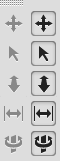
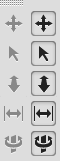
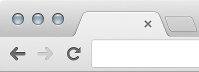
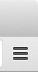
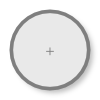
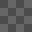
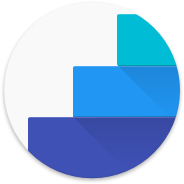
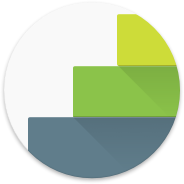
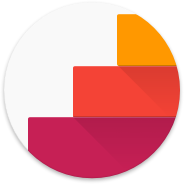
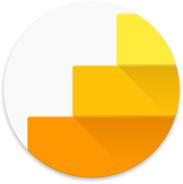

In [3]:
notebook_launcher(training_loop, num_processes = 3, use_port = '29501')
jupytertracerviz.visualize(glob('trace_*.json'), height = "800")